## MNIST 분류로 살펴보는 Learning Rate 찾기

In [1]:
from torchvision import datasets, transforms
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import math
sns.set()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [2]:
batch_size = 64
test_batch_size = 100

![architecture](https://raw.githubusercontent.com/kcy1019/TIL/images/mnist-cnn-1.png)
CNN에서 흔하게 보이는 구조입니다(e.g. vgg16). 여기서는 데이터가 단순하기 때문에 히든 레이어가 2개인 얕은 구조를 사용합니다.
마지막 부분의 Global Average Pooling을 통해 각 채널을 1x1 로 줄이면 연산량을 줄이면서도 dense layer처럼 이용할 수 있습니다. 각 채널이 dense layer 내의 한 개의 뉴런을 대신하는 것이죠.

In [3]:
class ConvNet(nn.Module):
    def __init__(self, input_size=(28, 28), output_size=10, num_layers=3, growth=2):
        super(ConvNet, self).__init__()
        self.num_layers = num_layers
        layers, channels, initial_growth = [], 1, 16
        for i in range(num_layers):
            next_channels = int(channels * growth * initial_growth)
            layers.append(nn.Conv2d(channels, next_channels, kernel_size=3, bias=False))
            init.kaiming_uniform(layers[-1].weight.data)
            layers.append(nn.BatchNorm2d(next_channels))
            layers[-1].weight.data.fill_(1)
            layers[-1].bias.data.fill_(0)
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            channels, initial_growth = next_channels, 1
        self.filter = nn.Sequential(*layers)
        self.classifier = nn.Linear(in_features=channels, out_features=10, bias=False)
        init.kaiming_uniform(self.classifier.weight.data)

    def forward(self, batch):
        return F.log_softmax(self.classifier(F.adaptive_avg_pool2d(self.filter(batch), 1).squeeze()), dim=1)

In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=test_batch_size, shuffle=True)

### Evenly spaced in {log, linear}-scale

0.00001 부터 10.0 까지의 수 중에서 n개의 값을 균일한 간격으로 뽑으려면 어떻게 해야 할까요? 두 가지 방법을 생각해 봅시다:

1. `(0.00001 + 10) * i / n`: '값의 구간'을 균일한 간격으로 나누어서 선택
2. `10 ** (-2 + 1) * i / n`: '지수 구간'를 균일한 간격으로 나누어서 선택

간단히 돌려보면 결과가 다음과 같이 나옵니다.
![architecture](https://raw.githubusercontent.com/kcy1019/TIL/images/evenly-spaced.png)

그냥 값의 구간을 균일하게 나눌 경우, 양 끝(특히 큰 쪽)에 몰리는 경향을 발견할 수 있습니다.
극단적으로 0.0001 ~ 0.5 사이의 값은 선택되지 않게 됩니다.

따라서 여기서는 지수 구간을 균일하게 나누어 learning rate를 선택하도록 합니다.

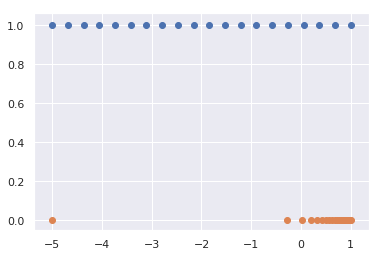

In [5]:
n = 20
plt.scatter(np.log10(np.logspace(-5 , 1, n)), [1] * n);
plt.scatter(np.log10(np.linspace(10 ** -5 , 10, n)), [0] * n);

### Finding Learning Rate

Learning rate(이하 lr)을 찾는 것은 생각보다 쉽습니다. 이 방법은 fast.ai 라이브러리에 구현된 것으로, [Cyclical Learning Rate][cyclic] 에서 아이디어를 얻었다고 합니다.

1. 낮은 lr부터 시작하여, lr을 계속 늘려가며 loss의 변화를 관찰한다 (loss vs. lr 그래프)
2. loss가 지속적으로 줄어드는 가장 큰 lr을 선택한다

굉장히 간단합니다. 다만.. 실제로 그냥 그려보면 다음과 같이 알아보기 힘든 그래프가 나옵니다. 어느 값까지 봐야하는지도 헷갈리고.

![loss-lr](https://raw.githubusercontent.com/kcy1019/TIL/images/lr-loss-graph-1.png)

이를 해결하기 위해 이 구현은 smoothing 방법으로 [EMA](ema)를 이용하고, 지금까지의 최소 (smoothed) loss 보다 4배 이상 큰 loss가 나오면 그만 보는 방법을 제안합니다.

위의 그래프에서 smoothed loss 를 보면, 가장 좋아보이는 지수가 -2.0과 -1.5의 중간쯤에 있는 것으로 보입니다.

[cyclic]: https://arxiv.org/abs/1506.01186
[ema]: https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average

In [6]:
def find_lr(model, train_dl, epochs=1, start=1e-4, end=8.0, beta=0.98):
    optimizer = optim.SGD(model.parameters(), lr=start, momentum=0.99)
    avg_loss, best_loss = 0, float('inf')
    step = (end / start) ** (1/(len(train_dl) * epochs - 1))
    i, lr = 1, start
    lr_losses = []
    for _ in range(epochs):
        for data, labels in train_dl:
            input, target = Variable(data).cuda(), Variable(labels).cuda()
            model.zero_grad()
            optimizer.zero_grad()
            output = model(input)
            loss = F.nll_loss(output, target)
            avg_loss = beta * avg_loss + (1-beta) * loss.data.item()
            smoothed_loss = avg_loss / (1 - beta ** i)
            lr_losses.append((lr, smoothed_loss, loss.data.item()))
            if smoothed_loss > 4 * best_loss:
                return lr_losses
            elif smoothed_loss < best_loss:
                best_loss = smoothed_loss
            loss.backward()
            optimizer.step()
            lr *= step
            optimizer.param_groups[0]['lr'] = lr
            i += 1
    return lr_losses

In [7]:
torch.manual_seed(42)
net = ConvNet(num_layers=3).cuda()
net.train()
lr_losses = find_lr(net, train_loader, epochs=1)

/home/lucent/.pyenv/versions/3.7.0/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  if __name__ == '__main__':
/home/lucent/.pyenv/versions/3.7.0/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


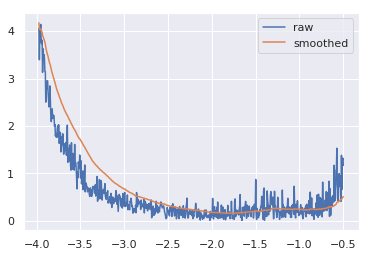

In [8]:
xs, ys = ([math.log10(p[0]) for p in lr_losses[5:-10]], [p[-1] for p in lr_losses[5:-10]])
plt.plot(xs, ys)
xs, ys = ([math.log10(p[0]) for p in lr_losses[5:-10]], [p[1] for p in lr_losses[5:-10]])
plt.plot(xs, ys)
plt.legend(['raw', 'smoothed'], ncol=1, loc='upper right');

In [9]:
def eval(model, test_dl):
    model.eval()
    num_examples, avg_loss, correct_count = 0, 0, 0
    with torch.no_grad():
        for data, labels in test_dl:
            input = Variable(data).cuda()
            output = model(input)
            loss = F.nll_loss(output, labels.cuda())
            avg_loss += loss.data.item()
            correct_count += np.sum(np.argmax(output.cpu().numpy(), axis=1) == labels.cpu().numpy())
            num_examples += labels.size(0)
        return avg_loss / num_examples, correct_count * 100 / num_examples

In [10]:
def train(model, train_dl, epochs=10, lr=0.1):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.99)
    avg_losses, accs = [], []
    for _ in range(epochs):
        model.train()
        avg_loss, acc, num_examples = 0, 0, 0
        for data, labels in train_dl:
            input, target = Variable(data).cuda(), Variable(labels).cuda()
            model.zero_grad()
            optimizer.zero_grad()
            output = model(input)
            loss = F.nll_loss(output, target)
            avg_loss += loss.data.item()
            acc += np.sum(np.argmax(output.detach().cpu().numpy(), axis=1) == labels.cpu().numpy())
            num_examples += target.size(0)
            loss.backward()
            optimizer.step()
        avg_loss /= num_examples
        acc = acc * 100 / num_examples
        val_avg_loss, val_acc = eval(model, test_loader)  # 원래는 validation dataset을 써야 하지만 MNIST엔 없어서..
        print(f'Epoch [{_+1:2d}/{epochs:2d}]: (Train) avg loss {avg_loss:.5f}, accuracy {acc:.3f}%')
        print(f'Epoch [{_+1:2d}/{epochs:2d}]: (Valid) avg loss {val_avg_loss:.5f}, accuracy {val_acc:.3f}%')
        avg_losses.append(avg_loss)
        accs.append(acc)
    return avg_losses, accs

### Training with Various Learning Rates

위에서 얻은 구간을 이용하여 learning rate를 찾아봅시다.
이번에도 지수 공간에서 균일하게 lr을 몇개 뽑아서 트레이닝과 테스트를 해 보면, 대충 0.02371 정도가 좋아보입니다.

In [11]:
losses, accs, lrs = [], [], np.logspace(-2 , -1.5, 5)
for lr in lrs:
    torch.manual_seed(42)
    net = ConvNet(num_layers=2).cuda()
    print(f'[LR = {lr:.5f}]')
    l, a = train(net, train_loader, epochs=5, lr=10 ** -1.75)
    losses.append(l)
    accs.append(a)

/home/lucent/.pyenv/versions/3.7.0/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  if __name__ == '__main__':
/home/lucent/.pyenv/versions/3.7.0/envs/ml2/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


[LR = 0.01000]
Epoch [ 1/ 5]: (Train) avg loss 0.00785, accuracy 83.557%
Epoch [ 1/ 5]: (Valid) avg loss 0.00258, accuracy 92.660%
Epoch [ 2/ 5]: (Train) avg loss 0.00231, accuracy 95.557%
Epoch [ 2/ 5]: (Valid) avg loss 0.00127, accuracy 96.190%
Epoch [ 3/ 5]: (Train) avg loss 0.00173, accuracy 96.570%
Epoch [ 3/ 5]: (Valid) avg loss 0.00169, accuracy 94.300%
Epoch [ 4/ 5]: (Train) avg loss 0.00145, accuracy 97.243%
Epoch [ 4/ 5]: (Valid) avg loss 0.00083, accuracy 97.510%
Epoch [ 5/ 5]: (Train) avg loss 0.00112, accuracy 97.828%
Epoch [ 5/ 5]: (Valid) avg loss 0.00080, accuracy 97.580%
[LR = 0.01334]
Epoch [ 1/ 5]: (Train) avg loss 0.00788, accuracy 83.497%
Epoch [ 1/ 5]: (Valid) avg loss 0.00254, accuracy 92.640%
Epoch [ 2/ 5]: (Train) avg loss 0.00234, accuracy 95.445%
Epoch [ 2/ 5]: (Valid) avg loss 0.00144, accuracy 95.610%
Epoch [ 3/ 5]: (Train) avg loss 0.00168, accuracy 96.772%
Epoch [ 3/ 5]: (Valid) avg loss 0.00106, accuracy 96.690%
Epoch [ 4/ 5]: (Train) avg loss 0.00138, a